Поляризация. Модель. Авдеев Роман

**Версия обновлена 19.03.2023**

# Imports

In [1]:
import pandas as pd
import numpy as np
import pymorphy2
import openpyxl
import shutil
import random
import io, codecs, re, os, sys, json, string, csv, datetime

from collections import Counter
from collections import defaultdict

# from pymystem3 import Mystem
from string import punctuation
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from scipy.spatial.distance import cdist
from statistics import mean, mode

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV

import dataframe_image as dfi

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Авдеев\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Авдеев\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Авдеев\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Авдеев\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df_sovpad = pd.read_excel(r"C:\laba\duplicate_colab_data\df_sovpad.xlsx")

In [3]:
df_sovpad.head(2)

,doc_id,text_group_id,domain,text,sentiment,pub_date,lemm_sentences,sentences,topics_info
0,8355,48b345a1-0d3d-4df8-ae7a-862d55f16fde,kommersant.ru,"Президент США Джо Байден снова заявил, что Ваш...","{'neg': {}, 'pos': {'США': 1, 'Москвы': 1}}",2021-05-06 07:29:00,байден сша искать конфликт россия президент сш...,"['Байден: США не ищут конфликта с Россией.', '...","{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
1,4908,77085a14-c648-4207-a555-d7d3987400fd,tsargrad.tv,Генсек НАТО испугался дружбы России и Белорусс...,"{'neg': {'НАТО': 2, 'России': 3, 'Белоруссии':...",2021-05-06 11:19:00,генсек нато испугаться дружба россия белорусси...,['Генсек НАТО испугался дружбы России и Белору...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."


In [4]:
toloka = pd.read_csv(r"C:\laba\duplicate_colab_data\toloka.tsv", delimiter='\t').dropna(how='all').reset_index()

In [5]:
toloka.head(2)

,index,INPUT:id,INPUT:text,OUTPUT:pole,OUTPUT:doc_id,OUTPUT:pole_name,GOLDEN:pole,GOLDEN:doc_id,GOLDEN:pole_name,HINT:text,HINT:default_language,ASSIGNMENT:link,ASSIGNMENT:task_id,ASSIGNMENT:assignment_id,ASSIGNMENT:task_suite_id,ASSIGNMENT:worker_id,ASSIGNMENT:status,ASSIGNMENT:started,ASSIGNMENT:accepted
0,0,1020.0,В Иркутске в начале мая росгвардеец застрелил ...,other_topic,1020.0,Не относится к теме,NaN,NaN,NaN,NaN,NaN,https://sandbox.toloka.yandex.com/task/1046375...,13dd6852-68fc-4856-af0b-dd5fe61a4a75,00000ff767--61b1393df0511e2e3dd77be7,00000ff767--61ae5a9c3f9df01ff0b583d1,07947fa51c6a1d996956f30fef7efa68,APPROVED,2021-12-08T23:01:17.842,2021-12-08T23:02:24.963
1,1,1019.0,В Иркутске росгвардеец застрелил местного жите...,pole_1,1019.0,Поляризация1,NaN,NaN,NaN,NaN,NaN,https://sandbox.toloka.yandex.com/task/1046375...,22f230cd-d003-489f-b9fe-e3224d55ee9b,00000ff767--61b1393df0511e2e3dd77be7,00000ff767--61ae5a9c3f9df01ff0b583d1,07947fa51c6a1d996956f30fef7efa68,APPROVED,2021-12-08T23:01:17.842,2021-12-08T23:02:24.963


#### Spacy

In [7]:
! pip install pydantic==1.10.2

In [6]:
import spacy

In [7]:
! python -m spacy download ru_core_news_sm

     --------------------------------------- 15.3/15.3 MB 18.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [10]:
! python -m spacy info


============================== Info about spaCy ==============================

spaCy version    3.5.0                         
Location         C:\lab\lib\site-packages\spacy
Platform         Windows-10-10.0.22000-SP0     
Python version   3.9.12                        
Pipelines        ru_core_news_sm (3.5.0)       



# Data prepare

In [8]:
print('Всего документов:', df_sovpad.shape[0])

Всего документов: 452


In [9]:
print('Список разметчиков и сколько документов каждый из них разметил:')
toloka['ASSIGNMENT:worker_id'].value_counts()

Список разметчиков и сколько документов каждый из них разметил:


be6dd5ed06926c811c121ff0b99d0459    443
57ff7fa2bd80df2ebe1d954b6fef520e    443
3ed0bce4b4375e5b9962640f69fabca2    259
4bfc93d2d535ccc0fe2eebc2d33e6740    131
027b00cba0c5d7791dada81921a1ad70     32
930bb16c0e629e039a95d5bb1f560df2     29
b390c2edc497a8d11e3b709067e8a006     10
07947fa51c6a1d996956f30fef7efa68      9
Name: ASSIGNMENT:worker_id, dtype: int64

## Methods

In [10]:
# маркируем полюсы в толоке лейблами (-1) - нерелевантный(other_topic); (0) - нейтральный(without_polarization); (k) - номер указанного полюса(pole_k)

def marking_toloka_poles(toloka):
    toloka.insert(4, 'pole_mark', np.nan)
    for i in range(toloka.shape[0]):
        if toloka.at[i, 'OUTPUT:pole'] == 'other_topic':
            toloka.at[i, 'pole_mark'] = -1
        elif toloka.at[i, 'OUTPUT:pole'] == 'without_polarization':
            toloka.at[i, 'pole_mark'] = 0
        elif 'pole_' in str(toloka.at[i, 'OUTPUT:pole']):
            mark = int(toloka.at[i, 'OUTPUT:pole'][5])
            if mark == 0:
                mark = 9
            toloka.at[i, 'pole_mark'] = mark

In [11]:
# рассмотрим метки каждого документа: для каждого документа выпишем три метки (тк три асессора) для последующего анализа. Разметку каждого из экспертов считает верной

def check_docs_labels(toloka):
    
    '''def most_common(List):
        return(mode(List))'''
    
    data_doc_labels = pd.DataFrame(columns={'doc_id', 'label_1', 'label_2', 'label_3'})
    data_doc_labels['doc_id'] = list((toloka['OUTPUT:doc_id'].value_counts().index).astype(int)) #лист всех документов из толоки - 452 шт
    
    data_doc_labels = data_doc_labels[['doc_id', 'label_1', 'label_2', 'label_3']]
    
    # добавим столбец, куда будем записывать id разметчиков (пусть будет + контроль, что взяли метки у РАЗНЫХ асессоров)
    # ВАЖНО: workers - id экспертов из толоки, corpus_id - номер корпуса из df_sovpad (т.е. из исходного датасета)
    data_doc_labels.insert(4, 'workers', 'a')
    data_doc_labels.insert(1, 'corpus_id', 'a')
    
    for i in range(toloka.shape[0]):
        curr_doc_id = toloka.at[i, 'OUTPUT:doc_id']
        doc_index_in_df = data_doc_labels[data_doc_labels['doc_id'] == curr_doc_id].index[0] #находим строку в data_doc_labels с doc_id равным curr_doc_id
                
        if np.isnan(data_doc_labels.at[doc_index_in_df, 'label_1']):
            data_doc_labels.at[doc_index_in_df, 'label_1'] = toloka.at[i, 'pole_mark']
            worker_list = [toloka.at[i, 'ASSIGNMENT:worker_id']]
            data_doc_labels.at[doc_index_in_df, 'workers'] = worker_list
        elif np.isnan(data_doc_labels.at[doc_index_in_df, 'label_2']):
            data_doc_labels.at[doc_index_in_df, 'label_2'] = toloka.at[i, 'pole_mark']
            data_doc_labels.at[doc_index_in_df, 'workers'].append(toloka.at[i, 'ASSIGNMENT:worker_id'])
        else:
            np.isnan(data_doc_labels.at[doc_index_in_df, 'label_3'])
            data_doc_labels.at[doc_index_in_df, 'label_3'] = toloka.at[i, 'pole_mark']
            data_doc_labels.at[doc_index_in_df, 'workers'].append(toloka.at[i, 'ASSIGNMENT:worker_id'])
            
        
#    data_doc_labels.insert(4, 'final_label', np.nan)
    
#    for i in range(data_doc_labels.shape[0]):
#        if (data_doc_labels.at[i, 'label_1'] == data_doc_labels.at[i, 'label_2']) or (data_doc_labels.at[i, 'label_1'] == data_doc_labels.at[i, 'label_3']) or (data_doc_labels.at[i, 'label_2'] == data_doc_labels.at[i, 'label_3']):
#            data_doc_labels.at[i, 'final_label'] = int(most_common(list(data_doc_labels.iloc[i].values[:3])))

    return data_doc_labels

In [13]:
# записать номера корпусов из df_sovpad в data_doc_labels

def mark_corpus_id(data_doc_labels, df_sovpad):
    for i in range(data_doc_labels.shape[0]):
        curr_doc_id = data_doc_labels.at[i, 'doc_id']
        line_index_where_doc_id = df_sovpad[df_sovpad['doc_id'] == curr_doc_id].index[0]
        data_doc_labels.at[i, 'corpus_id'] = df_sovpad.at[line_index_where_doc_id, 'text_group_id']
        
    return data_doc_labels

In [15]:
'''# дополнительная фильтраци - убираем np.nan и одиночные полюсы после работы check_docs_labels

def clear_check_docs_labels(data_doc_labels):
    data_doc_labels = data_doc_labels.dropna()
    unique_labels = list(data_doc_labels['final_label'].value_counts()[data_doc_labels['final_label'].value_counts() == 1].index)
    data_doc_labels = data_doc_labels[data_doc_labels['final_label'].isin(unique_labels) == False]
    return data_doc_labels'''

"# дополнительная фильтраци - убираем np.nan и одиночные полюсы после работы check_docs_labels\n\ndef clear_check_docs_labels(data_doc_labels):\n    data_doc_labels = data_doc_labels.dropna()\n    unique_labels = list(data_doc_labels['final_label'].value_counts()[data_doc_labels['final_label'].value_counts() == 1].index)\n    data_doc_labels = data_doc_labels[data_doc_labels['final_label'].isin(unique_labels) == False]\n    return data_doc_labels"

In [14]:
# преобразовали столбец 'sentiment' из столбца строк в столбец словарей

def transform_to_dict(data):
    import ast
    data['sentiment'] = data['sentiment'].apply(lambda row: ast.literal_eval(row))

In [15]:
# выписать все слова из 'sentiment' для каждого документа в список

def extract_sent_words(data):
    data.insert(4, 'sent_words', '')
    all_sent_words = []
    for i in range(data.shape[0]):
        doc_sent_words = []
        for key in data.at[i, 'sentiment']['pos'].keys():
            doc_sent_words.append(key)
        for key in data.at[i, 'sentiment']['neg'].keys():
            doc_sent_words.append(key)
        data.at[i, 'sent_words'] = doc_sent_words
        all_sent_words += doc_sent_words
    return all_sent_words

In [16]:
#  выписать все слова из 'sentiment' для каждого документа в словарь БЕЗ разделения на neg и pos

def extract_sent_doc_to_dict(data):
    data.insert(4, 'sent_words_dict', '')
    for i in range(data.shape[0]):
        doc_sent = {}
        for key, value in data.at[i, 'sentiment']['neg'].items():
            if key in doc_sent.keys():
                doc_sent[key] += value
            else:
                doc_sent[key] = value
        for key, value in data.at[i, 'sentiment']['pos'].items():
            if key in doc_sent.keys():
                doc_sent[key] += value
            else:
                doc_sent[key] = value
        data.at[i, 'sent_words_dict'] = doc_sent

In [17]:
#  получаем большой общий словарь по всем документам (разделенный на neg и pos)

def create_all_sent_dict(data):
    all_sent_dict = {'neg':{}, 'pos':{}}
    for i in range(data.shape[0]):
        for key, value in data.at[i, 'sentiment']['neg'].items():
            if key in all_sent_dict['neg'].keys():
                all_sent_dict['neg'][key] += value
            else:
                all_sent_dict['neg'][key] = value
        for key, value in data.at[i, 'sentiment']['pos'].items():
            if key in all_sent_dict['pos'].keys():
                all_sent_dict['pos'][key] += value
            else:
                all_sent_dict['pos'][key] = value
    return all_sent_dict

In [18]:
#  получаем большой общий словарь по всем документам (БЕЗ разделения на neg и pos)

def create_joined_all_sent_dict(data):
    all_sent_dict = {}
    for i in range(data.shape[0]):
        for key, value in data.at[i, 'sentiment']['neg'].items():
            if key in all_sent_dict.keys():
                all_sent_dict[key] += value
            else:
                all_sent_dict[key] = value
        for key, value in data.at[i, 'sentiment']['pos'].items():
            if key in all_sent_dict.keys():
                all_sent_dict[key] += value
            else:
                all_sent_dict[key] = value
    return all_sent_dict

In [19]:
# tf-idf для каждого документа на основе сентиментов


def sent_tf_idf(data):
    # размерность вектора tf-idf - кол-во всех уникальных слов в нашем датасете
    # размерность матрицы = (кол-во документов, размерность вектора tf-df)
    # вектор tf-df для документа - соответствующая строка матрицы
    
    transform_to_dict(data)
    extract_sent_doc_to_dict(data)
    
    all_sent = create_joined_all_sent_dict(data)
    
    tf_idf_matrix = np.zeros((data.shape[0], len(all_sent.keys())))
    
    for i in range(data.shape[0]):
        
        tfidf_df = pd.DataFrame({'word': [], 'tfidf': []}) 
        tfidf_df['word'] = all_sent.keys()
        tfidf_df['tfidf'] = 0
        
        all_doc_sent_amount = sum(data.at[i, 'sent_words_dict'].values())   # кол-во уникальных слов в соответствующей колонке для данного документа
    
        for key, value in data.at[i, 'sent_words_dict'].items():
            
            tf = value/all_doc_sent_amount    
            
            doc_key_count = 0
            for j in range(data.shape[0]):
                if key in data.at[j, 'sent_words_dict'].keys():
                    doc_key_count += 1    
                
            idf = np.log(data.shape[0]/doc_key_count)
            
            tfidf = tf*idf
            word_index = tfidf_df[tfidf_df['word'] == key].index[0]
            tfidf_df.at[word_index, 'tfidf'] = tfidf
        
        tf_idf_matrix[i] = tfidf_df['tfidf'].to_numpy()
    
    return tf_idf_matrix

In [20]:
# выбор лучшего числа кластеров для kmeans

def inertia_comparing(inertia):
  y_axis = inertia
  k_coeffs = []
  for i in range(2, len(inertia)):
    M1 = np.array([[float(i-1), 1.], [float(i), 1.]])
    v1 = np.array([float(inertia[i-2]), float(inertia[i-1])])
    k, b = np.linalg.solve(M1, v1)
    k_coeffs.append(k)
  
  max_delta = 0
  n_clust = 0
  for i in range(1, len(k_coeffs)):
    if abs(k_coeffs[i-1] - k_coeffs[i]) > max_delta:
      max_delta = abs(k_coeffs[i-1] - k_coeffs[i])
      n_clust = i
  return n_clust

In [21]:
# извлекаем соответствующий корпус из толоки

def extract_corpus_from_toloka(toloka, docs_ids):
  toloka_corpus_data = pd.DataFrame(columns = toloka.columns.values)
  for i in range(toloka.shape[0]):
    if toloka.at[i, 'INPUT:id'] in docs_ids:
      toloka_corpus_data = toloka_corpus_data.append(toloka.iloc[i], ignore_index=True)
  return toloka_corpus_data

In [22]:
# проверяем соответствие id корпуса из данных и из толоки(они в толоке и дате разные, а id документов одинаковые)

def equal_toloka_data_group_ids(toloka_gr_id, data_gr_id, toloka_data_corpuses_ids):
  flag = False
  for i in range(toloka_data_corpuses_ids.shape[0]):
    if toloka_data_corpuses_ids.at[i, 'toloka'] == toloka_gr_id and toloka_data_corpuses_ids.at[i, 'data'] == data_gr_id:
      flag = True
      break
  return flag

In [23]:
def corpus_to_tf_idf(corpus):
  text = corpus['lemm_sentences']
  #text = join_strs(corpus['text'])
  #text = preprocessing(text)
  tfidfconverter = TfidfVectorizer(stop_words=nltk_stopwords.words('russian'))
  tfidf = tfidfconverter.fit_transform(text)
  return tfidf

In [24]:
def train_kmeans(X, klasters):
    kmeans = KMeans(n_clusters=klasters, algorithm='auto', init='k-means++', max_iter=300)
    kmeans.fit(X.reshape(-1, 1))
    return kmeans

In [25]:
def modeling_for_curr_corpus(tfidf):
  inertias = []
  K = range(1, 10)

  for k in K:
      # Building and fitting the model
      
      kmeansModel = train_kmeans(tfidf, k)
      inertias.append(kmeansModel.inertia_)

  kmeansModel = train_kmeans(tfidf, inertia_comparing(inertias))
  return kmeansModel

## Metrics

In [25]:
'''# измерение качества, метрика M1 (точность и полнота кластеризации мнений)

# полагаем, что на вход дается X с мнениями-кластерами и Y - экспертна разметка

def M1(X, Y):
    X = list(X)
    Y = list(np.array(Y).astype(int))
    clusters_amount = len(set(X))
    cluster_names = np.unique(X)
    P_list = []
    R_list = []
    
    for i in range(clusters_amount):
        sum_labels_i = 0
        for k in range(len(X)):
            if Y[k] == cluster_names[i] and X[k] == cluster_names[i]:
                sum_labels_i += 1
        sum_x = X.count(cluster_names[i])
        sum_y = Y.count(cluster_names[i])
        
        if sum_x == 0:
            P_i = 0
        else:
            P_i = sum_labels_i/sum_x
            
        if sum_y == 0:
            R_i = 0
        else:
            R_i = sum_labels_i/sum_y
        
        P_list.append(P_i)
        R_list.append(R_i)
        
    P = np.mean(P_list)
    R = np.mean(R_list)
    
    return 2 * P * R /(P + R)
    '''

'# измерение качества, метрика M1 (точность и полнота кластеризации мнений)\n\n# полагаем, что на вход дается X с мнениями-кластерами и Y - экспертна разметка\n\ndef M1(X, Y):\n    X = list(X)\n    Y = list(np.array(Y).astype(int))\n    clusters_amount = len(set(X))\n    cluster_names = np.unique(X)\n    P_list = []\n    R_list = []\n    \n    for i in range(clusters_amount):\n        sum_labels_i = 0\n        for k in range(len(X)):\n            if Y[k] == cluster_names[i] and X[k] == cluster_names[i]:\n                sum_labels_i += 1\n        sum_x = X.count(cluster_names[i])\n        sum_y = Y.count(cluster_names[i])\n        \n        if sum_x == 0:\n            P_i = 0\n        else:\n            P_i = sum_labels_i/sum_x\n            \n        if sum_y == 0:\n            R_i = 0\n        else:\n            R_i = sum_labels_i/sum_y\n        \n        P_list.append(P_i)\n        R_list.append(R_i)\n        \n    P = np.mean(P_list)\n    R = np.mean(R_list)\n    \n    return 2 * P 

In [26]:
# измерение качества, метрика M1 (точность и полнота кластеризации мнений)

# полагаем, что на вход дается X с мнениями-кластерами и Y - экспертна разметка

def M1(X, Y):
    X = list(X)
    Y = list(np.array(Y).astype(int))
    P_list = []
    R_list = []
    
    for i in range(len(X)):
        x_i = X[i]
        y_i = Y[i]
        sum_labels_i = 0
        sum_x = 0
        sum_y = 0
        for k in range(len(X)):
            if  X[k] == x_i and Y[k] == y_i:
                sum_labels_i += 1
                sum_x += 1
                sum_y += 1
            elif X[k] == x_i:
                sum_x += 1
            elif Y[k] == y_i:
                sum_y += 1
        
        if sum_x == 0:
            P_i = 0
        else:
            P_i = sum_labels_i/sum_x
            
        if sum_y == 0:
            R_i = 0
        else:
            R_i = sum_labels_i/sum_y
        
        P_list.append(P_i)
        R_list.append(R_i)
        
    P = np.mean(P_list)
    R = np.mean(R_list)
    
    return 2 * P * R /(P + R)

In [27]:
# измерение качества, метрика M2 (точность и полнота определения нейтральных сообщений)

# полагаем, что на вход дается list X с нейтральными докуменатми и Y - список нейтральных из толоки

def M2(X, Y):
    sum_labels = 0
    
    for i in range(len(X)):
        if  X[i] == 0 and Y[i] == 0:
            sum_labels += 1
    sum_x = X.count(0)
    sum_y = Y.count(0)
    if sum_x == 0:
        P_0 = 0
    else:
        P_0 = sum_labels/sum_x 
            
    if sum_y == 0:
        return np.nan
    else:
        R_0 = sum_labels/sum_y
        if P_0 + R_0 == 0:
            return 0
        else:
            return 2 * P_0 * R_0 /(P_0 + R_0)    

In [28]:
# измерение качества, метрика M3 (точность и полнота определения нерелевантных сообщений)

# полагаем, что на вход дается list X с other_topic докуменатми (y_pred) и Y - список other_topic из толоки (y_true)

def M3(X, Y):
    sum_labels = 0
    for i in range(len(X)):
        if Y[i] == -1 and X[i] == -1:
            sum_labels += 1
    sum_x = X.count(-1)
    sum_y = Y.count(-1)
    if sum_x == 0:
        P_1 = 0
    else:
        P_1 = sum_labels/sum_x 
            
    if sum_y == 0:
        return np.nan
    else:
        R_1 = sum_labels/sum_y
        if (P_1 + R_1) == 0:
            return 0
        else:  
            return 2 * P_1 * R_1 /(P_1 + R_1)

In [29]:
# измерение качества, метрика M4 (точность определения числа мнений)

# X - ответ алогритма, Y - экспертная разметка
 
def M4(X, Y):
  K_x = float(len(set(list(X))))
  K_y = float(len(set(Y)))
  return min([K_x, K_y])/max([K_x, K_y])

## Usage

In [30]:
marking_toloka_poles(toloka)
toloka.head(2)

,index,INPUT:id,INPUT:text,OUTPUT:pole,pole_mark,OUTPUT:doc_id,OUTPUT:pole_name,GOLDEN:pole,GOLDEN:doc_id,GOLDEN:pole_name,HINT:text,HINT:default_language,ASSIGNMENT:link,ASSIGNMENT:task_id,ASSIGNMENT:assignment_id,ASSIGNMENT:task_suite_id,ASSIGNMENT:worker_id,ASSIGNMENT:status,ASSIGNMENT:started,ASSIGNMENT:accepted
0,0,1020.0,В Иркутске в начале мая росгвардеец застрелил ...,other_topic,-1.0,1020.0,Не относится к теме,NaN,NaN,NaN,NaN,NaN,https://sandbox.toloka.yandex.com/task/1046375...,13dd6852-68fc-4856-af0b-dd5fe61a4a75,00000ff767--61b1393df0511e2e3dd77be7,00000ff767--61ae5a9c3f9df01ff0b583d1,07947fa51c6a1d996956f30fef7efa68,APPROVED,2021-12-08T23:01:17.842,2021-12-08T23:02:24.963
1,1,1019.0,В Иркутске росгвардеец застрелил местного жите...,pole_1,1.0,1019.0,Поляризация1,NaN,NaN,NaN,NaN,NaN,https://sandbox.toloka.yandex.com/task/1046375...,22f230cd-d003-489f-b9fe-e3224d55ee9b,00000ff767--61b1393df0511e2e3dd77be7,00000ff767--61ae5a9c3f9df01ff0b583d1,07947fa51c6a1d996956f30fef7efa68,APPROVED,2021-12-08T23:01:17.842,2021-12-08T23:02:24.963


In [31]:
data_doc_labels = check_docs_labels(toloka)
data_doc_labels = mark_corpus_id(data_doc_labels, df_sovpad)
data_doc_labels

,doc_id,corpus_id,label_1,label_2,label_3,workers
0,1020,5157cb93-7a0e-4485-a715-fa36d3ca94cb,-1.0,9.0,9.0,"[07947fa51c6a1d996956f30fef7efa68, be6dd5ed069..."
1,591,50ae73b5-3dd0-4298-b04b-aa0496000eb0,1.0,1.0,5.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
2,4009,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
3,4013,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
4,9284,28db5916-80dc-42f9-a822-5f14259b0e14,9.0,3.0,0.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
...,...,...,...,...,...,...
447,1365,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
448,1071,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
449,6040,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
450,8353,48b345a1-0d3d-4df8-ae7a-862d55f16fde,1.0,1.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


### Работаем с корпусами 

In [32]:
data_doc_labels['corpus_id'].value_counts()

6415b59f-a6cf-4789-93cb-98024289ba74    33
5c24dfbd-f3b5-4608-892f-80cd2ec82f27    33
50ae73b5-3dd0-4298-b04b-aa0496000eb0    29
48b345a1-0d3d-4df8-ae7a-862d55f16fde    27
77085a14-c648-4207-a555-d7d3987400fd    24
c80e8aa3-ca56-44c1-8ed7-868d2c78a52c    24
4ab6d1a4-f530-451c-bcfa-852c7784e9f6    18
28db5916-80dc-42f9-a822-5f14259b0e14    17
d8e5332d-7da1-491c-bf3a-248b10a56c30    16
3c2da57c-c42f-4897-b5e7-7b44855baae6    14
3975555d-2f8b-48a4-85ed-7ce390c04618    14
dceb2da8-3a81-4210-80b5-c6ed1b682acf    14
6d98268c-df5e-4700-8192-c2633f5fbd99    13
46509952-8146-4262-9bb0-d77d94dab5ef    13
42f49e66-6d17-4869-adb4-3b0ebf51fc87    13
bb470657-d3a9-4c90-b7f4-95beaead5ae7    13
f3fcb2bf-44ec-4c68-bce2-23bde9e14ebd    12
51e55b2f-611c-48f3-8310-8fb12bfaab94    12
905d170a-569b-4ee9-ae32-86bdb33f7309    11
17af2621-05bd-4008-a8f5-4afe64a4e823    11
3af7ccba-dc12-4d24-8271-298204826729    10
4cd6fbbd-3123-4d87-9a2e-a0ce0eae933c    10
9deaeb05-f44b-4c3b-83e7-c44fbe762b4c    10
ec2e2478-82

In [33]:
df_sovpad[df_sovpad['text_group_id'] == '1bcad992-3329-4807-8ac5-920aee3c0db8']

,doc_id,text_group_id,domain,text,sentiment,pub_date,lemm_sentences,sentences,topics_info
194,3273,1bcad992-3329-4807-8ac5-920aee3c0db8,rt.com,Советник руководителя офиса украинского презид...,"{'neg': {}, 'pos': {}}",2021-05-07 21:31:00,украина анонсировать телефонный переговоры зел...,['На Украине анонсировали телефонные переговор...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
199,4097,1bcad992-3329-4807-8ac5-920aee3c0db8,kommersant.ru,Президенты Украины и США Владимир Зеленский и ...,"{'neg': {}, 'pos': {}}",2021-05-07 21:59:00,советник офис зеленский анонсировать разговор ...,['Советник офиса Зеленского анонсировал его ра...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
202,4095,1bcad992-3329-4807-8ac5-920aee3c0db8,inforeactor.ru,Чтобы быть в курсе самых важных новостей и чит...,"{'neg': {}, 'pos': {}}",2021-05-07 22:08:00,офис президент украина анонсировать переговоры...,['В офисе президента Украины анонсировали пере...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
203,4092,1bcad992-3329-4807-8ac5-920aee3c0db8,piter.tv,Лидеры стран обменяются мнениями по острым воп...,"{'neg': {}, 'pos': {}}",2021-05-07 22:16:00,зеленский байден провести телефонный переговор...,['Зеленский и Байден проведут телефонные перег...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
207,3261,1bcad992-3329-4807-8ac5-920aee3c0db8,bfm.ru,Все новости В рамках беседы лидеры обменяются...,"{'neg': {}, 'pos': {}}",2021-05-07 22:22:00,зеленский байден провести телефонный разговор ...,['Зеленский и Байден проведут телефонный разго...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
211,4087,1bcad992-3329-4807-8ac5-920aee3c0db8,5-tv.ru,Фото: ТАСС / Яковлева Ирина Лидеру Украины Вла...,"{'neg': {'Владимир Зеленский': 1}, 'pos': {'СШ...",2021-05-07 22:51:00,зеленский байден назначить телефонный перегово...,['Зеленский и Байден назначили телефонные пере...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."


In [34]:
df_sovpad[df_sovpad['text_group_id'] == 'e71483bd-ddc8-40ef-a8b7-e55fe532cb0e']

,doc_id,text_group_id,domain,text,sentiment,pub_date,lemm_sentences,sentences,topics_info
195,4102,e71483bd-ddc8-40ef-a8b7-e55fe532cb0e,rt.com,Советник руководителя офиса украинского презид...,"{'neg': {}, 'pos': {}}",2021-05-07 21:31:00,украина анонсировать телефонный переговоры зел...,['На Украине анонсировали телефонные переговор...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
198,4098,e71483bd-ddc8-40ef-a8b7-e55fe532cb0e,vz.ru,В понедельник состоится телефонный разговор пр...,"{'neg': {}, 'pos': {'Зеленский': 1}}",2021-05-07 21:53:00,киев анонсировать телефонный разговор зеленски...,['В Киеве анонсировали телефонный разговор Зел...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
201,4094,e71483bd-ddc8-40ef-a8b7-e55fe532cb0e,slovodel.com,На Украине сообщили о предстоящем разговоре Ба...,"{'neg': {}, 'pos': {}}",2021-05-07 22:08:00,украина сообщить предстоящий разговор байден з...,['На Украине сообщили о предстоящем разговоре ...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."


Рассмотрев корпуса '1bcad992-3329-4807-8ac5-920aee3c0db8' и 'e71483bd-ddc8-40ef-a8b7-e55fe532cb0e', видим, что это одна и то же событие, поэтому объединим два корпуса в один. Но запомним, что '1bcad992-3329-4807-8ac5-920aee3c0db8' = 'e71483bd-ddc8-40ef-a8b7-e55fe532cb0e'

In [35]:
data_doc_labels[data_doc_labels['corpus_id'] == 'e71483bd-ddc8-40ef-a8b7-e55fe532cb0e']

,doc_id,corpus_id,label_1,label_2,label_3,workers
34,4094,e71483bd-ddc8-40ef-a8b7-e55fe532cb0e,0.0,2.0,1.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
36,4098,e71483bd-ddc8-40ef-a8b7-e55fe532cb0e,0.0,3.0,1.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
37,4102,e71483bd-ddc8-40ef-a8b7-e55fe532cb0e,0.0,2.0,1.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


In [36]:
data_doc_labels.at[34, 'corpus_id'] = '1bcad992-3329-4807-8ac5-920aee3c0db8'
data_doc_labels.at[36, 'corpus_id'] = '1bcad992-3329-4807-8ac5-920aee3c0db8'
data_doc_labels.at[37, 'corpus_id'] = '1bcad992-3329-4807-8ac5-920aee3c0db8'

In [37]:
corpuses_doc_statistics = pd.DataFrame(data_doc_labels['corpus_id'].value_counts())
corpuses_doc_statistics = corpuses_doc_statistics.rename(columns={'corpus_id': 'docs_number'})
corpuses_doc_statistics

,docs_number
5c24dfbd-f3b5-4608-892f-80cd2ec82f27,33
6415b59f-a6cf-4789-93cb-98024289ba74,33
50ae73b5-3dd0-4298-b04b-aa0496000eb0,29
48b345a1-0d3d-4df8-ae7a-862d55f16fde,27
77085a14-c648-4207-a555-d7d3987400fd,24
c80e8aa3-ca56-44c1-8ed7-868d2c78a52c,24
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,18
28db5916-80dc-42f9-a822-5f14259b0e14,17
d8e5332d-7da1-491c-bf3a-248b10a56c30,16
3c2da57c-c42f-4897-b5e7-7b44855baae6,14


In [ ]:
dfi.export(corpuses_doc_statistics, "corpuses_doc_statistics.png")

In [39]:
print('Проверили, получили, что всего 30 корпусов:', len(np.unique(list(data_doc_labels['corpus_id']))))

Проверили, получили, что всего 30 корпусов: 30


### Проверяем экспертов и перекрытие разметки

In [40]:
check_workers_amount = {1:0, 2:0, 3:0}

for i in range(data_doc_labels.shape[0]):
    check_workers_amount[len(data_doc_labels.at[i, 'workers'])] += 1

In [41]:
check_workers_amount

{1: 0, 2: 11, 3: 441}

Выше получили, что из 452 документов 441 документ проработали 3 эксперта, а 11 документов проработали только 2 асессора (или 3, но один не проставил метку полюса)

In [107]:
# data_doc_labels = clear_check_docs_labels(data_doc_labels)

In [108]:
'''# выборка чистых данных из толоки с однозначно определенными полюсами

data_doc_labels = data_doc_labels.sort_values('doc_id').reset_index(drop=True)
data_doc_labels'''

"# выборка чистых данных из толоки с однозначно определенными полюсами\n\ndata_doc_labels = data_doc_labels.sort_values('doc_id').reset_index(drop=True)\ndata_doc_labels"

In [109]:
# data_doc_labels['final_label'].value_counts()

In [42]:
data_doc_labels

,doc_id,corpus_id,label_1,label_2,label_3,workers
0,1020,5157cb93-7a0e-4485-a715-fa36d3ca94cb,-1.0,9.0,9.0,"[07947fa51c6a1d996956f30fef7efa68, be6dd5ed069..."
1,591,50ae73b5-3dd0-4298-b04b-aa0496000eb0,1.0,1.0,5.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
2,4009,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
3,4013,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
4,9284,28db5916-80dc-42f9-a822-5f14259b0e14,9.0,3.0,0.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
...,...,...,...,...,...,...
447,1365,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
448,1071,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
449,6040,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
450,8353,48b345a1-0d3d-4df8-ae7a-862d55f16fde,1.0,1.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


In [43]:
print('Сколько раз NAN встречается в каждом столбце таблицы:')
data_doc_labels.isna().sum()

Сколько раз NAN встречается в каждом столбце таблицы:


doc_id        0
corpus_id     0
label_1       0
label_2       5
label_3      39
workers       0
dtype: int64

In [44]:
print('Всего строк в таблице, в которых есть хотя б один NAN: ', len(data_doc_labels.index[data_doc_labels.isnull().any(axis=1)].tolist()))

Всего строк в таблице, в которых есть хотя б один NAN:  39


Получается, что для 413 документов у нас есть три метки, а для 39 документов - только одна метка. Значит, при тестировании для 413 документов учитываем все три разметки(считаем для каждой, а потом усредняем по разметкам), а для 39 документов ориентируемся на одну единственную разметку

### Составляем датасеты для тестирования

**Составим три набора лейблов для тестирования (3 разметки с оставленными NAN):**

In [45]:
expert1 = list(data_doc_labels['label_1'])
expert2 = list(data_doc_labels['label_2'])
expert3 = list(data_doc_labels['label_3'])

**Сформируем три датафрема: Разметка 1го асессора + место для ответа модели, резметка 2го асессора + место для ответа модели, резметка 3го асессора + место для ответа модели**

In [46]:
data_testing_1 = pd.DataFrame(columns={'model', 'worker_1'})
data_testing_1['worker_1'] = expert1
    
data_testing_2 = pd.DataFrame(columns={'model', 'worker_2'})
data_testing_2['worker_2'] = expert2

data_testing_3 = pd.DataFrame(columns={'model', 'worker_3'})
data_testing_3['worker_3'] = expert3

In [141]:
# список документов из чистых данных для тестирования (233 шт.)

# doc_ids_for_test = list(data_doc_labels['doc_id'].values)

In [142]:
# true_labels = list(data_doc_labels['final_label'].values)

# Modeling

## Noise detection new (spacy)

In [47]:
corpus_ids_list = list(np.unique(data_doc_labels['corpus_id'])) # список всех рассмтариваемых корпусов, всего 30 шт, айдишники взяты из исхного датасета(не из толоки)

In [48]:
import spacy
from sklearn.cluster import OPTICS
nlp = spacy.load("ru_core_news_sm")

### Тестируем на одном корпусе

In [217]:
test1 = data_doc_labels[data_doc_labels['corpus_id'] == corpus_ids_list[0]]
test1

,doc_id,corpus_id,label_1,label_2,label_3,workers
284,2558,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
312,2563,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
314,2524,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
315,2525,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
316,2526,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
317,9104,17af2621-05bd-4008-a8f5-4afe64a4e823,0.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
318,9105,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
319,9106,17af2621-05bd-4008-a8f5-4afe64a4e823,2.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
320,9108,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
321,9109,17af2621-05bd-4008-a8f5-4afe64a4e823,2.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."


In [218]:
docs = list(test1['doc_id'])

In [219]:
test1_semantic = pd.DataFrame(columns={'doc1', 'doc2', 'similarity'})

In [220]:
k = 0
for i in range(len(docs)):
    for j in range(i+1, len(docs)):
        test1_semantic.at[k, 'doc1'] = docs[i]
        test1_semantic.at[k, 'doc2'] = docs[j]
        k += 1

In [221]:
for i in range(test1_semantic.shape[0]):
    doc1_id = df_sovpad[df_sovpad['doc_id'] == test1_semantic.at[i, 'doc1']].index[0]
    doc1 = nlp(df_sovpad.at[doc1_id, 'lemm_sentences'])
    
    doc2_id = df_sovpad[df_sovpad['doc_id'] == test1_semantic.at[i, 'doc2']].index[0]
    doc2 = nlp(df_sovpad.at[doc2_id, 'lemm_sentences'])
    
    test1_semantic.at[i, 'similarity'] = doc1.similarity(doc2)

C:\Users\Авдеев\AppData\Local\Temp\ipykernel_21628\2854430277.py:8: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  test1_semantic.at[i, 'similarity'] = doc1.similarity(doc2)


In [333]:
test1_semantic = test1_semantic.sort_values(by=['similarity'])

In [312]:
test1_semantic.head(3)

,doc1,doc2,similarity,label
35,2526,9105,0.822305,-1
48,9105,9111,0.832726,-1
22,2524,9105,0.854841,-1


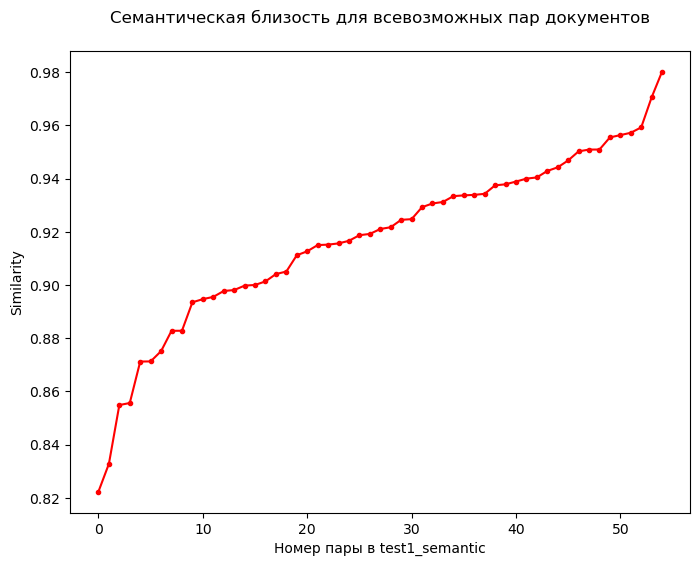

In [334]:
plt.figure(figsize=(8, 6))
plt.title('Семантическая близость для всевозможных пар документов', pad=20)
plt.xlabel('Номер пары в test1_semantic')
plt.ylabel('Similarity')
plt.plot(np.arange(test1_semantic.shape[0]), test1_semantic['similarity'], 'r', marker='.')
plt.show()

In [344]:
from sklearn.cluster import OPTICS

db = OPTICS(max_eps=0.5, min_samples=3)
db.fit(np.array(test1_semantic['similarity']).reshape(-1, 1))

OPTICS(max_eps=0.5, min_samples=3)

In [345]:
db.labels_

array([-1,  7,  1,  9, -1,  9, -1,  5,  8,  7, -1,  1,  5,  3,  7,  3,  2,
        6,  6, -1, -1,  7, -1,  8,  4, -1,  2,  2,  6,  9, -1,  2,  3,  1,
        3, -1, -1,  2,  7,  4, -1,  2,  0,  4,  6,  9,  9,  8, -1,  0,  0,
        5,  0,  2, -1])

In [226]:
test1_semantic.insert(3, 'label', 0)

In [346]:
test1_semantic['label'] = db.labels_

In [347]:
test1_semantic = test1_semantic.sort_index()

In [348]:
test1_semantic.head(5)

,doc1,doc2,similarity,label
0,2558,2563,0.980231,-1
1,2558,2524,0.898084,7
2,2558,2525,0.950229,1
3,2558,2526,0.882782,9
4,2558,9104,0.905042,-1


In [349]:
docs

[2558, 2563, 2524, 2525, 2526, 9104, 9105, 9106, 9108, 9109, 9111]

In [350]:
docs_labels = []

for doc in docs:
    doc_dict = {}
    for i in range(test1_semantic.shape[0]):
        if test1_semantic.at[i, 'doc1'] == doc or test1_semantic.at[i, 'doc2'] == doc:
            if test1_semantic.at[i, 'label'] not in doc_dict.keys():
                doc_dict[test1_semantic.at[i, 'label']] = 1
            else:
                doc_dict[test1_semantic.at[i, 'label']] += 1
    print(doc_dict)
    docs_labels.append(max(doc_dict, key=doc_dict.get))

{-1: 3, 7: 2, 1: 1, 9: 2, 5: 1, 8: 1}
{-1: 2, 1: 1, 5: 1, 3: 2, 7: 1, 2: 1, 6: 2}
{7: 2, -1: 5, 8: 1, 4: 1, 2: 1}
{1: 3, -1: 2, 2: 2, 6: 1, 9: 1, 3: 1}
{9: 1, 5: 1, -1: 3, 2: 2, 3: 1, 7: 1, 4: 1}
{-1: 2, 3: 2, 7: 1, 6: 2, 2: 1, 0: 1, 4: 1}
{9: 4, 7: 1, -1: 4, 8: 1}
{-1: 3, 3: 1, 8: 1, 2: 1, 9: 1, 0: 2, 5: 1}
{5: 1, 2: 4, 4: 1, 0: 3, 9: 1}
{8: 2, 6: 1, -1: 2, 3: 1, 7: 1, 4: 1, 0: 2}
{7: 1, 6: 2, 2: 2, 1: 1, 4: 1, -1: 2, 5: 1}


In [352]:
M3(docs_labels, list(test1['label_1']))

nan

In [353]:
M3(docs_labels, list(test1['label_2']))

nan

In [351]:
M3(docs_labels, list(test1['label_3']))

0.8

### Тестируем на всем датасете

In [49]:
data_doc_labels

,doc_id,corpus_id,label_1,label_2,label_3,workers
0,1020,5157cb93-7a0e-4485-a715-fa36d3ca94cb,-1.0,9.0,9.0,"[07947fa51c6a1d996956f30fef7efa68, be6dd5ed069..."
1,591,50ae73b5-3dd0-4298-b04b-aa0496000eb0,1.0,1.0,5.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
2,4009,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
3,4013,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
4,9284,28db5916-80dc-42f9-a822-5f14259b0e14,9.0,3.0,0.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
...,...,...,...,...,...,...
447,1365,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
448,1071,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
449,6040,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
450,8353,48b345a1-0d3d-4df8-ae7a-862d55f16fde,1.0,1.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


In [50]:
total_results = pd.DataFrame(columns={'M3_1', 'M3_2', 'M3_3'}, index=list(np.unique(data_doc_labels['corpus_id'])))
total_results = total_results[['M3_1', 'M3_2', 'M3_3']]

In [51]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [52]:
for corpus_id in tqdm(corpus_ids_list):
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id]
    
    docs = list(test['doc_id'])
    test_semantic = pd.DataFrame(columns={'doc1', 'doc2', 'similarity'})
    
    k = 0
    for i in range(len(docs)):
        for j in range(i+1, len(docs)):
            test_semantic.at[k, 'doc1'] = docs[i]
            test_semantic.at[k, 'doc2'] = docs[j]
            k += 1
            
    for i in range(test_semantic.shape[0]):
        doc1_id = df_sovpad[df_sovpad['doc_id'] == test_semantic.at[i, 'doc1']].index[0]
        doc1 = nlp(df_sovpad.at[doc1_id, 'lemm_sentences'])
    
        doc2_id = df_sovpad[df_sovpad['doc_id'] == test_semantic.at[i, 'doc2']].index[0]
        doc2 = nlp(df_sovpad.at[doc2_id, 'lemm_sentences'])
    
        test_semantic.at[i, 'similarity'] = doc1.similarity(doc2)
        
    test_semantic = test_semantic.sort_values(by=['similarity'])

    optics = OPTICS(max_eps=1, min_samples=5)
    optics.fit(np.array(test_semantic['similarity']).reshape(-1, 1))
    
    test_semantic.insert(3, 'label', 0)
    test_semantic['label'] = optics.labels_
    test_semantic = test_semantic.sort_index()
    
    docs_labels = []

    for doc in docs:
        doc_dict = {}
        for i in range(test_semantic.shape[0]):
            if test_semantic.at[i, 'doc1'] == doc or test_semantic.at[i, 'doc2'] == doc:
                if test_semantic.at[i, 'label'] not in doc_dict.keys():
                    doc_dict[test_semantic.at[i, 'label']] = 1
                else:
                    doc_dict[test_semantic.at[i, 'label']] += 1
        docs_labels.append(max(doc_dict, key=doc_dict.get))
        
    total_results.at[corpus_id, 'M3_1'] = M3(docs_labels, list(test['label_1']))
    total_results.at[corpus_id, 'M3_2'] = M3(docs_labels, list(test['label_2']))
    total_results.at[corpus_id, 'M3_3'] = M3(docs_labels, list(test['label_3']))

100%|██████████| 30/30 [06:24<00:00, 12.82s/it]


In [64]:
total_results

,M3_1,M3_2,M3_3
17af2621-05bd-4008-a8f5-4afe64a4e823,NaN,NaN,0.444444
1bcad992-3329-4807-8ac5-920aee3c0db8,NaN,NaN,NaN
28db5916-80dc-42f9-a822-5f14259b0e14,NaN,NaN,NaN
3975555d-2f8b-48a4-85ed-7ce390c04618,NaN,0,NaN
3af7ccba-dc12-4d24-8271-298204826729,NaN,NaN,NaN
3c2da57c-c42f-4897-b5e7-7b44855baae6,0,0,0.142857
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.166667,0.7,NaN
46509952-8146-4262-9bb0-d77d94dab5ef,0.666667,0.666667,0.666667
48b345a1-0d3d-4df8-ae7a-862d55f16fde,0.074074,0.074074,NaN
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,NaN,NaN,NaN


In [63]:
total_results[total_results is not np.NaN]

KeyError: True

## Noise deletion (old)

In [211]:
df_sovpad_for_test = df_sovpad.copy()

sent_tdidf_matrix = sent_tf_idf(df_sovpad_for_test)

In [408]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [412]:
df_sovpad_for_test

,doc_id,text_group_id,domain,text,sent_words_dict,sentiment,pub_date,lemm_sentences,sentences,topics_info
0,8355,48b345a1-0d3d-4df8-ae7a-862d55f16fde,kommersant.ru,"Президент США Джо Байден снова заявил, что Ваш...","{'США': 1, 'Москвы': 1}","{'neg': {}, 'pos': {'США': 1, 'Москвы': 1}}",2021-05-06 07:29:00,байден сша искать конфликт россия президент сш...,"['Байден: США не ищут конфликта с Россией.', '...","{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
1,4908,77085a14-c648-4207-a555-d7d3987400fd,tsargrad.tv,Генсек НАТО испугался дружбы России и Белорусс...,"{'НАТО': 4, 'России': 3, 'Белоруссии': 5, 'Аль...","{'neg': {'НАТО': 2, 'России': 3, 'Белоруссии':...",2021-05-06 11:19:00,генсек нато испугаться дружба россия белорусси...,['Генсек НАТО испугался дружбы России и Белору...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
2,4907,77085a14-c648-4207-a555-d7d3987400fd,tvzvezda.ru,Члены НАТО обеспокоены сотрудничеством России ...,"{'Сергей Шойгу': 1, 'Минобороны': 1}","{'neg': {}, 'pos': {'Сергей Шойгу': 1, 'Минобо...",2021-05-06 11:24:00,генсек нато обеспокоить сотрудничество россия ...,['Генсек НАТО обеспокоен сотрудничеством Росси...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
3,4906,77085a14-c648-4207-a555-d7d3987400fd,vz.ru,Сотрудничество России и Белоруссии беспокоит ч...,"{'Москвы': 1, 'Минска': 1, 'Белоруссии': 1}","{'neg': {'Москвы': 1}, 'pos': {'Минска': 1, 'Б...",2021-05-06 11:31:00,нато обещать защищать союзник угроза сторона м...,['НАТО обещало защищать союзников от «угроз» с...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
4,4905,77085a14-c648-4207-a555-d7d3987400fd,kommersant.ru,Генеральный секретарь НАТО Йенс Столтенберг за...,"{'Москвы': 1, 'Россия': 1, 'Грузии': 1, 'Молда...","{'neg': {'Москвы': 1, 'Россия': 1, 'Грузии': 1...",2021-05-06 11:38:00,генсек нато выразить обеспокоенность сотруднич...,['Генсек НАТО выразил обеспокоенность сотрудни...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
...,...,...,...,...,...,...,...,...,...,...
447,8188,6d98268c-df5e-4700-8192-c2633f5fbd99,echoperm.ru,В программах Без указания или любая программа ...,{'Перми': 1},"{'neg': {'Перми': 1}, 'pos': {}}",2021-05-22 16:13:00,пермь студент колледж пгниу напасть нож таксис...,['В Перми студенты колледжа ПГНИУ напали с нож...,{'topics': [{'lvl1': {'id': 'lvl1_проишествия'...
448,8187,6d98268c-df5e-4700-8192-c2633f5fbd99,ura.news,Владимир Жабриков URA.RU Три студента пермск...,"{'URA': 1, 'МВД края': 1, 'Пермскому краю': 3,...","{'neg': {'URA': 1, 'МВД края': 1, 'Пермскому к...",2021-05-22 16:59:00,трое пермский студент пытаться убить таксист р...,['Трое пермских студентов пытались убить такси...,{'topics': [{'lvl1': {'id': 'lvl1_проишествия'...
449,8186,6d98268c-df5e-4700-8192-c2633f5fbd99,gorodovoy.ru,Трое учащихся пермского колледжа угнали автомо...,"{'Перми': 1, 'России': 2, 'Гайва': 1}","{'neg': {'Перми': 1}, 'pos': {'России': 2, 'Га...",2021-05-22 18:01:00,пермь подросток изрезать таксист кататься горо...,['В Перми подростки изрезали таксиста и катали...,{'topics': [{'lvl1': {'id': 'lvl1_проишествия'...
450,8185,6d98268c-df5e-4700-8192-c2633f5fbd99,progorod59.ru,Фото Pro Город Злоумышленников было трое В Пер...,"{'Перми': 3, 'Pro': 1, 'Злоумышленников': 1, '...","{'neg': {'Перми': 3, 'Pro': 1, 'Злоумышленнико...",2021-05-22 18:02:00,пермь студент нож ударить таксист кататься маш...,['В Перми студенты ножом ударили таксиста и ка...,{'topics': [{'lvl1': {'id': 'lvl1_проишествия'...


[-1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1  0  0  0  0  0 -1 -1 -1 -1  0 -1 -1
  0  0 -1  0 -1 -1 -1  0 -1  0 -1 -1 -1  0 -1 -1 -1 -1 -1  0 -1 -1 -1 -1
 -1  0  0 -1 -1 -1  0  0  0 -1  0 -1  0  0 -1 -1 -1 -1 -1 -1 -1  0 -1 -1
 -1 -1  0 -1  0  0  0  0  0 -1  0  0 -1 -1 -1  0  0 -1 -1 -1 -1  0  0  0
  0  0  0  0 -1  0 -1  0 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1  0  0
 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  0  0 -1 -1 -1 -1  0 -1 -1 -1
 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1  0  0 -1  0 -1 -1 -1  0  0 -1 -1
 -1  0 -1 -1  0 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1  0 -1  0 -1 -1  0 -1 -1
  0  0  0  0 -1  0 -1  0  0  0  0  0 -1 -1 -1  0  0 -1  0 -1  0 -1 -1  0
 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  0 -1 -1 -1 -1  0  0  0  0  0 -1  0  0
  0  0  0  0  0 -1  0  0 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

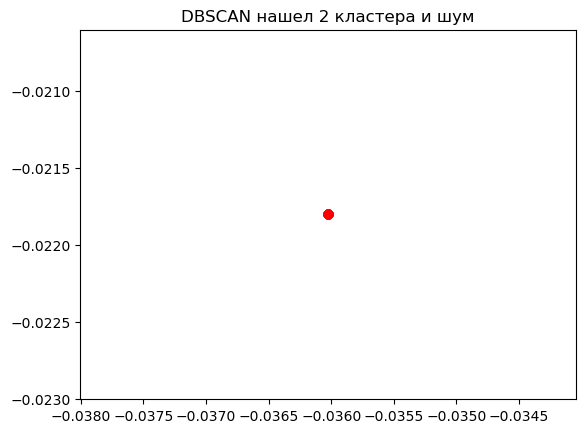

In [407]:
from sklearn.decomposition import PCA 

dbscan = DBSCAN(algorithm='auto', eps=0.0001, min_samples=5, n_jobs=-1, metric='euclidean')
dbscan.fit(sent_tdidf_matrix)

pca = PCA(n_components=2).fit(sent_tdidf_matrix)
pca_2d = pca.transform(sent_tdidf_matrix)

print(dbscan.labels_)
# Строим в соответствии с тремя классами
for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='o')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')
    '''elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='b', marker='.')'''

# plt.legend([c1, c3], ['Кластер 1', 'Шум'])
plt.title('DBSCAN нашел 2 кластера и шум')
plt.show()

In [216]:
# transform_to_dict(df_sovpad_for_test) - датасет['sentiment'] уже приведен из string к dict

In [367]:
eps = np.linspace(0.0001, 1, num=100)
min_samples = np.arange(2, 10)
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
metric = ['euclidean', 'seuclidean', 'cityblock','cosine', 'correlation', 'hamming', 'jaccard']
jobs = [-1]
tuned_parameters = {'eps': eps, 'min_samples': min_samples,  'n_jobs': jobs, 'algorithm' : algorithm, 'metric': metric}

grid_search = GridSearchCV(DBSCAN(), tuned_parameters, scoring=M3, n_jobs=-1)
grid_search.fit(sent_tdidf_matrix, data_testing_1['worker_1'])
print(grid_search.best_params_)

c:\lab\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
32000 fits failed out of a total of 112000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4000 fits failed with the following error:
Traceback (most recent call last):
  File "c:\lab\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\lab\lib\site-packages\sklearn\cluster\_dbscan.py", line 373, in fit
    neighbors_model.fit(X)
  File "c:\lab\lib\site-packages\sklearn\neighbors\_unsupervised.py", line 166, in fit
    return self._fit(X)
  File "c:\lab\lib\site-packages\sklearn\neighbors\_base.py", line 549, in _fit
    self._tree = BallTree(
  File "sklea

{'algorithm': 'auto', 'eps': 0.0001, 'metric': 'euclidean', 'min_samples': 2, 'n_jobs': -1}


c:\lab\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


In [369]:
print(grid_search.best_params_)

{'algorithm': 'auto', 'eps': 0.0001, 'metric': 'euclidean', 'min_samples': 2, 'n_jobs': -1}


In [374]:
db_a = DBSCAN(algorithm='auto', eps=0.0001, min_samples=2, n_jobs=-1, metric='euclidean').fit(sent_tdidf_matrix)
y_pred = db_a.labels_

**Проверка качества выделения нерелевантных**

In [376]:
data_testing_1['model'] = y_pred
data_testing_2['model'] = y_pred
data_testing_3['model'] = y_pred

ValueError: Length of values (621) does not match length of index (452)

Сравнение с 1ой разметкой:

In [372]:
data_testing_1 = data_testing_1[data_testing_1['worker_1'].notna()]
data_testing_1

,model,worker_1
0,-1,-1.0
1,-1,1.0
2,-1,1.0
3,-1,1.0
4,-1,9.0
...,...,...
447,-1,9.0
448,-1,9.0
449,-1,9.0
450,-1,1.0


In [373]:
M3(data_testing_1['model'], data_testing_1['worker_1'])

0.14326647564469913

Сравнение со 2ой разметкой:

In [293]:
data_testing_2 = data_testing_2[data_testing_2['worker_2'].notna()]
data_testing_2

,worker_2,model
0,9.0,-1
1,1.0,-1
2,1.0,-1
3,1.0,-1
4,3.0,-1
...,...,...
447,2.0,-1
448,2.0,-1
449,2.0,-1
450,1.0,-1


In [294]:
M3(data_testing_2['model'], data_testing_2['worker_2'])

0.19786096256684493

Сравнение с 3ей разметкой:

In [295]:
data_testing_3 = data_testing_3[data_testing_3['worker_3'].notna()]
data_testing_3

,model,worker_3
0,-1,9.0
1,-1,5.0
4,-1,0.0
5,-1,0.0
6,-1,0.0
...,...,...
447,-1,9.0
448,-1,9.0
449,-1,9.0
450,-1,9.0


In [296]:
M3(data_testing_3['model'], data_testing_3['worker_3'])

0.1884498480243161

## Noise deletion (extra old)

In [168]:
# датасет для теста

df_sovpad_for_test = df_sovpad[df_sovpad['doc_id'].isin(doc_ids_for_test) == True]
df_sovpad_for_test = df_sovpad_for_test.sort_values('doc_id').reset_index(drop=True)
df_sovpad_for_test.head(2)

,doc_id,text_group_id,domain,text,sentiment,pub_date,lemm_sentences,sentences,topics_info
0,84,a2defc9b-ba3b-4f3e-94b7-f07e72cae431,newinform.com,#россия #мвд #вытрезвители Находящихся в состо...,"{'neg': {}, 'pos': {'России': 1}}",2021-05-08 00:39:00,россия окончательно утвердить правило помещени...,['В России окончательно утвердили правила поме...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
1,106,a2defc9b-ba3b-4f3e-94b7-f07e72cae431,ptzgovorit.ru,Забирать в вытрезвители россиян будут и с улиц...,"{'neg': {}, 'pos': {}}",2021-05-07 23:12:00,забирать вытрезвитель россиянин быть улица дом...,['Забирать в вытрезвители россиян будут и с ул...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."


In [169]:
sent_tdidf_matrix = sent_tf_idf(df_sovpad_for_test)

In [ ]:
transform_to_dict(df_sovpad_for_test)

In [ ]:
nus = np.arange(0.001, 1, 0.001)
gammas = np.arange(0.001, 1, 0.001)
tuned_parameters = {'kernel' : ['rbf'], 'gamma' : gammas, 'nu': nus}

grid_search = GridSearchCV(OneClassSVM(), tuned_parameters, scoring=M3, n_jobs=4)
grid_search.fit(sent_tdidf_matrix, true_labels)
print(grid_search.best_params_)

In [171]:
clf = OneClassSVM(kernel='rbf', nu=0.22, gamma=0.03, max_iter=500000, tol=0.00001).fit(sent_tdidf_matrix)
y_pred = clf.predict(sent_tdidf_matrix)

In [172]:
y_pred

array([ 1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,
        1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  1,
       -1,  1,  1], dtype=int64)

In [173]:
M3(y_pred, true_labels)

0.3076923076923077

In [466]:
unique, counts = np.unique(y_pred, return_counts=True)

print(np.asarray((unique, counts)).T)

[[ -1  24]
 [  1 209]]


In [ ]:
other_topic_index = np.where(y_pred == -1)[0]
other_topic_index

In [ ]:
df_other_topic = df_sovpad.loc[other_topic_index]

In [ ]:
doc_ids_model = list(df_sovpad.loc[other_topic_index]['doc_id'])

In [ ]:
list_toloka_other_topic = []

for i in range(toloka.shape[0]):
    if toloka.at[i, 'OUTPUT:pole'] == 'other_topic':
        list_toloka_other_topic.append(i)
        
doc_ids_toloka = list(toloka.loc[list_toloka_other_topic]['INPUT:id'])
merge_other_topics = list(set(doc_ids_model) & set(doc_ids_toloka))

In [ ]:
toloka.loc[list_toloka_other_topic]

## Neutral docs

In [61]:
transform_to_dict(df_sovpad)

In [57]:
#проверка на нейтральность

def neutral_checking(data):
  doc_marks = [1] * data.shape[0]
  df_neutral_documents = data.iloc[0:0]
  df_not_neutral_documents = data.iloc[0:0]
  
  for i in range(data.shape[0]):
    if data.at[i, 'sentiment']['neg'] == {} and data.at[i, 'sentiment']['pos'] == {}:
      df_neutral_documents = pd.concat([df_neutral_documents, (data.loc[i]).to_frame().T])
      doc_marks[i] = 0
    else:
      df_not_neutral_documents = pd.concat([df_not_neutral_documents, (data.loc[i]).to_frame().T])
  return df_not_neutral_documents, df_neutral_documents, doc_marks

In [73]:
total_results.insert(3, 'M2_1', np.nan)
total_results.insert(4, 'M2_2', np.nan)
total_results.insert(5, 'M2_3', np.nan)

In [79]:
for corpus_id in tqdm(corpus_ids_list):
    corpus = df_sovpad[df_sovpad['text_group_id'] == corpus_id]
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id]
    
    df_not_neutral_documents, df_neutral_documents, neutral_marks = neutral_checking(corpus.reset_index(drop=True))

    total_results.at[corpus_id, 'M2_1'] = M2(neutral_marks, list(test['label_1']))
    total_results.at[corpus_id, 'M2_2'] = M2(neutral_marks, list(test['label_2']))
    total_results.at[corpus_id, 'M2_3'] = M2(neutral_marks, list(test['label_3']))

100%|██████████| 30/30 [00:00<00:00, 67.19it/s]


In [80]:
total_results

,M3_1,M3_2,M3_3,M2_1,M2_2,M2_3
17af2621-05bd-4008-a8f5-4afe64a4e823,NaN,NaN,0.444444,0.000000,0.000000,NaN
1bcad992-3329-4807-8ac5-920aee3c0db8,NaN,NaN,NaN,0.714286,NaN,0.285714
28db5916-80dc-42f9-a822-5f14259b0e14,NaN,NaN,NaN,NaN,NaN,0.000000
3975555d-2f8b-48a4-85ed-7ce390c04618,NaN,0,NaN,0.000000,NaN,NaN
3af7ccba-dc12-4d24-8271-298204826729,NaN,NaN,NaN,NaN,NaN,0.000000
3c2da57c-c42f-4897-b5e7-7b44855baae6,0,0,0.142857,NaN,NaN,0.000000
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.166667,0.7,NaN,NaN,NaN,NaN
46509952-8146-4262-9bb0-d77d94dab5ef,0.666667,0.666667,0.666667,NaN,NaN,NaN
48b345a1-0d3d-4df8-ae7a-862d55f16fde,0.074074,0.074074,NaN,NaN,NaN,0.125000
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,NaN,NaN,NaN,0.105263,NaN,NaN


## Clustering clear data

In [82]:
df_sovpad.head(2)

,doc_id,text_group_id,domain,text,sentiment,pub_date,lemm_sentences,sentences,topics_info
0,8355,48b345a1-0d3d-4df8-ae7a-862d55f16fde,kommersant.ru,"Президент США Джо Байден снова заявил, что Ваш...","{'neg': {}, 'pos': {'США': 1, 'Москвы': 1}}",2021-05-06 07:29:00,байден сша искать конфликт россия президент сш...,"['Байден: США не ищут конфликта с Россией.', '...","{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
1,4908,77085a14-c648-4207-a555-d7d3987400fd,tsargrad.tv,Генсек НАТО испугался дружбы России и Белорусс...,"{'neg': {'НАТО': 2, 'России': 3, 'Белоруссии':...",2021-05-06 11:19:00,генсек нато испугаться дружба россия белорусси...,['Генсек НАТО испугался дружбы России и Белору...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."


In [83]:
data_doc_labels.head(2)

,doc_id,corpus_id,label_1,label_2,label_3,workers
0,1020,5157cb93-7a0e-4485-a715-fa36d3ca94cb,-1.0,9.0,9.0,"[07947fa51c6a1d996956f30fef7efa68, be6dd5ed069..."
1,591,50ae73b5-3dd0-4298-b04b-aa0496000eb0,1.0,1.0,5.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


In [85]:
total_results.insert(6, 'M1_1', np.nan)
total_results.insert(7, 'M1_2', np.nan)
total_results.insert(8, 'M1_3', np.nan)

total_results.insert(9, 'M4_1', np.nan)
total_results.insert(10, 'M4_2', np.nan)
total_results.insert(11, 'M4_3', np.nan)

In [116]:
for corpus_id in tqdm(corpus_ids_list):
    corpus = df_sovpad[df_sovpad['text_group_id'] == corpus_id]
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id]
    
    tfidf = corpus_to_tf_idf(corpus.reset_index(drop=True))
    curr_kmeans_model = modeling_for_curr_corpus(tfidf)

    labels_model = curr_kmeans_model.fit_predict(tfidf)
    
    total_results.at[corpus_id, 'M1_1'] = M1(labels_model, list(test['label_1']))
    total_results.at[corpus_id, 'M1_2'] = M1(labels_model, list(test['label_2']))
    total_results.at[corpus_id, 'M1_3'] = M1(labels_model, list(test['label_3']))
    
    total_results.at[corpus_id, 'M4_1'] = M4(labels_model, list(test['label_1']))
    total_results.at[corpus_id, 'M4_2'] = M4(labels_model, list(test['label_2']))
    total_results.at[corpus_id, 'M4_3'] = M4(labels_model, list(test['label_3']))

100%|██████████| 30/30 [05:33<00:00, 11.11s/it]


In [120]:
total_results = round(total_results, 3)

In [121]:
total_results

,M3_1,M3_2,M3_3,M2_1,M2_2,M2_3,M1_1,M1_2,M1_3,M4_1,M4_2,M4_3
17af2621-05bd-4008-a8f5-4afe64a4e823,NaN,NaN,0.444444,0.0,0.0,NaN,0.726,1.000,0.699,0.333,1.000,0.500
1bcad992-3329-4807-8ac5-920aee3c0db8,NaN,NaN,NaN,1.0,NaN,0.0,1.000,0.667,0.839,1.000,0.333,0.500
28db5916-80dc-42f9-a822-5f14259b0e14,NaN,NaN,NaN,NaN,NaN,0.0,0.680,0.604,0.716,0.500,0.333,0.333
3975555d-2f8b-48a4-85ed-7ce390c04618,NaN,0,NaN,0.0,NaN,NaN,1.000,0.504,0.432,1.000,0.250,0.200
3af7ccba-dc12-4d24-8271-298204826729,NaN,NaN,NaN,NaN,NaN,0.0,0.901,0.734,0.901,0.500,0.500,0.500
3c2da57c-c42f-4897-b5e7-7b44855baae6,0,0,0.142857,NaN,NaN,0.0,0.515,0.559,0.515,0.200,0.250,0.200
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.166667,0.7,NaN,NaN,NaN,NaN,0.766,0.729,0.580,0.333,0.500,0.250
46509952-8146-4262-9bb0-d77d94dab5ef,0.666667,0.666667,0.666667,NaN,NaN,NaN,0.568,0.543,0.580,0.250,0.250,0.333
48b345a1-0d3d-4df8-ae7a-862d55f16fde,0.074074,0.074074,NaN,NaN,NaN,0.0,0.527,0.446,0.764,0.167,0.167,0.167
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,NaN,NaN,NaN,0.0,NaN,NaN,1.000,0.768,0.719,1.000,0.250,0.250


In [124]:
dfi.export(total_results, "table.png")

In [128]:
df_sovpad['text_group_id'].value_counts()

5c24dfbd-f3b5-4608-892f-80cd2ec82f27    33
6415b59f-a6cf-4789-93cb-98024289ba74    33
50ae73b5-3dd0-4298-b04b-aa0496000eb0    29
48b345a1-0d3d-4df8-ae7a-862d55f16fde    27
77085a14-c648-4207-a555-d7d3987400fd    24
c80e8aa3-ca56-44c1-8ed7-868d2c78a52c    24
4ab6d1a4-f530-451c-bcfa-852c7784e9f6    18
28db5916-80dc-42f9-a822-5f14259b0e14    17
d8e5332d-7da1-491c-bf3a-248b10a56c30    16
3c2da57c-c42f-4897-b5e7-7b44855baae6    14
dceb2da8-3a81-4210-80b5-c6ed1b682acf    14
3975555d-2f8b-48a4-85ed-7ce390c04618    14
42f49e66-6d17-4869-adb4-3b0ebf51fc87    13
6d98268c-df5e-4700-8192-c2633f5fbd99    13
46509952-8146-4262-9bb0-d77d94dab5ef    13
bb470657-d3a9-4c90-b7f4-95beaead5ae7    13
f3fcb2bf-44ec-4c68-bce2-23bde9e14ebd    12
51e55b2f-611c-48f3-8310-8fb12bfaab94    12
17af2621-05bd-4008-a8f5-4afe64a4e823    11
905d170a-569b-4ee9-ae32-86bdb33f7309    11
3af7ccba-dc12-4d24-8271-298204826729    10
9deaeb05-f44b-4c3b-83e7-c44fbe762b4c    10
4cd6fbbd-3123-4d87-9a2e-a0ce0eae933c    10
5da72401-32

### Красивый экспорт датафрейма в виде изображения

In [109]:
import six

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

<AxesSubplot:>

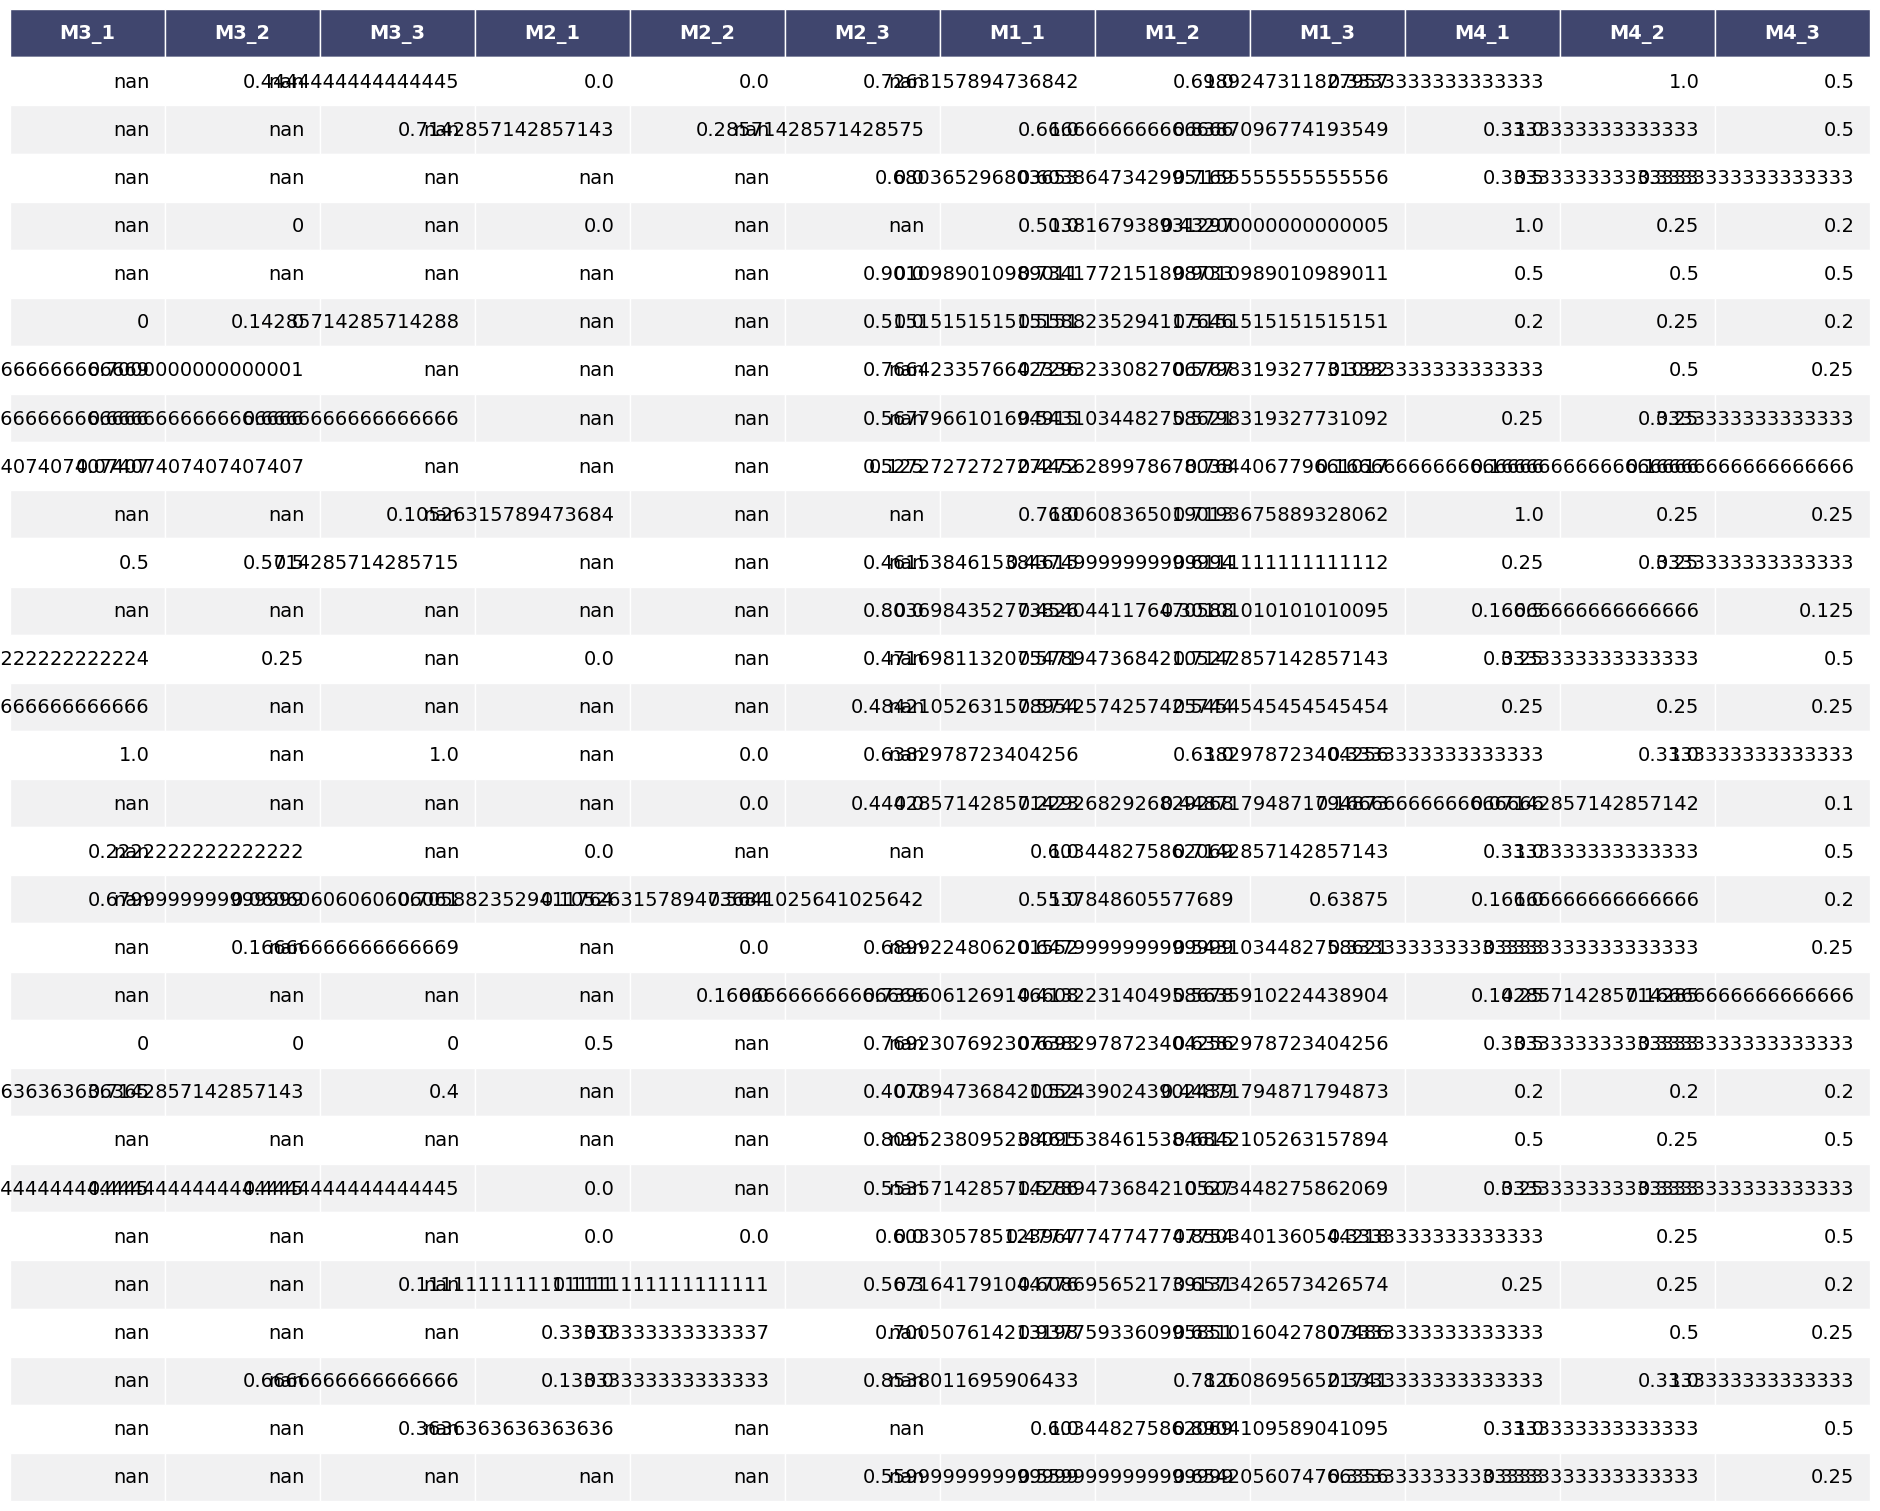

In [110]:
render_mpl_table(total_results, header_columns=0, col_width=2.0)

### Старая часть

In [391]:
# df_not_neutral_documents, df_neutral_documents = neutral_checking(df_sovpad)
df_clear = df_not_neutral_documents

In [389]:
list_toloka_without_pol = []
for i in range(toloka.shape[0]):
    if toloka.at[i, 'OUTPUT:pole'] == 'without_polarization':
        list_toloka_without_pol.append(i)

In [ ]:
extracted_corpuses = []

total_M_4 = []

clear_tfidf_matrix = sent_tf_idf(df_clear)

toloka_data_corpuses_ids = pd.DataFrame(columns = ['data', 'toloka']) # таблица соответствия id корпусов из толоки и из данных 
#file_results = open('/home/file_results.txt', 'w')

for i in range(df_clear.shape[0]):
  particular_corpus = extract_corpus(df_clear, extracted_corpuses)
  particular_docs_ids = list(particular_corpus['doc_id'])
  toloka_particular_corpus = extract_corpus_from_toloka(toloka, particular_docs_ids)
  toloka_data_corpuses_ids = toloka_data_corpuses_ids.append({'toloka': toloka_particular_corpus.at[0, 'ASSIGNMENT:task_suite_id'], 
                                                              'data': particular_corpus.at[0, 'text_group_id']}, ignore_index=True)
  '''
  # маркируем полученный корпус полюсами из толоки
  curr_worker = ''
  for i in range(toloka.shape[0]):
    if equal_toloka_data_group_ids(toloka.at[i, 'ASSIGNMENT:task_suite_id'], particular_corpus.at[0, 'text_group_id'], toloka_data_corpuses_ids):
        curr_worker = toloka.at[i, 'ASSIGNMENT:worker_id']
        break
  particular_corpus = poles_marking_from_toloka(toloka_particular_corpus, particular_corpus, toloka_data_corpuses_ids, particular_corpus.at[0, 'text_group_id'], curr_worker)
  rename_poles_particular_corpus(particular_corpus)
  tfidf = corpus_to_tf_idf(particular_corpus)
  curr_kmeans_model = modeling_for_curr_corpus(tfidf)
  '''
  used_tolokers = []
  particular_corpus.insert(2, 'toloka_poles', '')

  curr_M_4 = []

  for i in range(toloka_particular_corpus.shape[0]):
    curr_toloker = toloka_particular_corpus.at[i, 'ASSIGNMENT:worker_id']
    if curr_toloker not in used_tolokers:
      used_tolokers.append(curr_toloker)
      particular_corpus = poles_marking_from_toloka(toloka_particular_corpus, particular_corpus, toloka_data_corpuses_ids, particular_corpus.at[0, 'text_group_id'], curr_toloker)
      break
      '''rename_poles_particular_corpus(particular_corpus)
      tfidf = corpus_to_tf_idf(particular_corpus)
      curr_kmeans_model = modeling_for_curr_corpus(tfidf)

      labels_model = curr_kmeans_model.fit_predict(tfidf)
      labels_true = list(particular_corpus['toloka_poles'].astype(int))
      curr_M_4.append(M4(labels_model, labels_true))'''

  # total_M_4.append(sum(curr_M_4)/len(curr_M_4))
  
  #if len(extracted_corpuses) == 6:
  #  break

# Объединение разметок

In [144]:
data_doc_labels.insert(5, 'final_label', np.nan)

In [145]:
data_doc_labels

,doc_id,corpus_id,label_1,label_2,label_3,final_label,workers
0,1020,5157cb93-7a0e-4485-a715-fa36d3ca94cb,-1.0,9.0,9.0,NaN,"[07947fa51c6a1d996956f30fef7efa68, be6dd5ed069..."
1,591,50ae73b5-3dd0-4298-b04b-aa0496000eb0,1.0,1.0,5.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
2,4009,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
3,4013,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
4,9284,28db5916-80dc-42f9-a822-5f14259b0e14,9.0,3.0,0.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
...,...,...,...,...,...,...,...
447,1365,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
448,1071,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
449,6040,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
450,8353,48b345a1-0d3d-4df8-ae7a-862d55f16fde,1.0,1.0,9.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


In [ ]:
# определяем финальный лейбл для каждого документа

def define_final_label(data):
    for i in range(data.shape[0]):
        if (data.at[i, 'label_1'] == data.at[i, 'label_2']) or (data.at[i, 'label_1'] == data.at[i, 'label_3']) or (data.at[i, 'label_2'] == data.at[i, 'label_3']):
            